In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [2]:
from matrix_dft import matrix_dft, minimal_dft, make_pupil

In [3]:
pupil = make_pupil(0.5)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


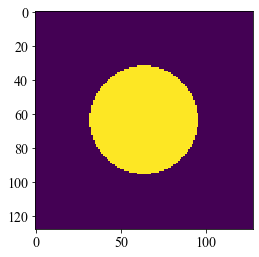

In [4]:
plt.imshow(pupil)

In [5]:
psf = matrix_dft(pupil, 10., 1024,
               offset=None, inverse=False, centering='ADJUSTABLE')

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'float'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [6]:


def get_psf(screen,nlam=64,npix=128):
    return jit_dft(pupil*np.exp(1.j*screen), nlam, npix)
    
def get_uv(psf):
    return jit_dft(np.abs(psf)**2, 128, 128)

def get_phases(screen):
    return np.angle(get_uv(get_psf(screen)))


In [7]:
jit_dft = jit(minimal_dft,static_argnums=2)

In [8]:

jit_phases = jit(get_phases)

In [9]:
%%time
psf = minimal_dft(pupil, 64., 128)

CPU times: user 125 ms, sys: 6.3 ms, total: 131 ms
Wall time: 119 ms


In [10]:
%%time
psf = jit_dft(pupil, 64., 128)

CPU times: user 98 ms, sys: 4.26 ms, total: 102 ms
Wall time: 101 ms


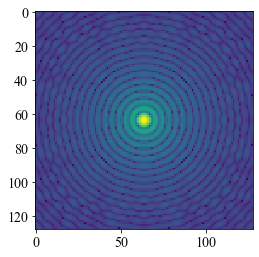

In [11]:
plt.imshow(np.abs(psf)**0.25)
# plt.xlim(500,524)
# plt.ylim(500,524)

In [12]:
uv = get_uv(psf)

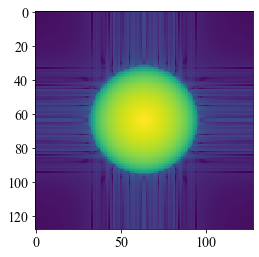

In [13]:
plt.imshow(np.abs(uv)**0.1)

In [14]:
from scipy.signal import correlate2d, convolve2d

In [15]:
padded = np.pad(pupil,64,mode='constant')

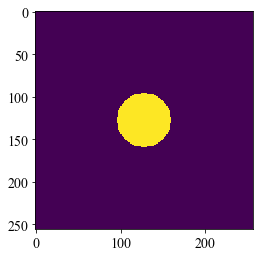

In [16]:
plt.imshow(padded)

In [17]:
# support = convolve2d(padded,padded,mode='same')>0

In [18]:
# plt.imshow(support)

In [19]:
from jax import jacfwd, jacrev


In [20]:
%%time
jit_phases(pupil)

CPU times: user 187 ms, sys: 8.11 ms, total: 196 ms
Wall time: 197 ms


DeviceArray([[-3.1412146e+00, -2.2789880e-03, -3.1376672e+00, ...,
              -3.1357455e+00, -3.1700262e-03, -3.1399405e+00],
             [ 2.0122479e-03,  3.1406145e+00,  4.6635242e-04, ...,
              -4.8597660e-03, -3.1364279e+00, -3.1419657e-03],
             [-3.1349127e+00, -1.1626897e-02, -3.1291358e+00, ...,
              -3.1384375e+00, -4.4322203e-04,  3.1385159e+00],
             ...,
             [-3.1385159e+00,  4.4322203e-04,  3.1384375e+00, ...,
               3.1291358e+00,  1.1626897e-02,  3.1349127e+00],
             [ 3.1419657e-03,  3.1364279e+00,  4.8597660e-03, ...,
              -4.6635242e-04, -3.1406145e+00, -2.0122479e-03],
             [ 3.1399405e+00,  3.1700262e-03,  3.1357455e+00, ...,
               3.1376672e+00,  2.2789880e-03,  3.1412146e+00]],            dtype=float32)

In [21]:
phasegrad = jacfwd(jit_phases)


In [22]:
phasegrad_rev = jacrev(jit_phases)

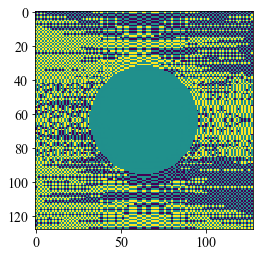

In [23]:
plt.imshow((jit_phases(pupil)))


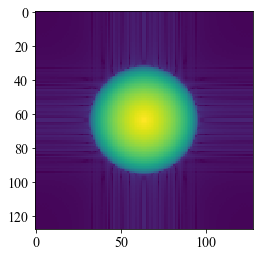

In [24]:
plt.imshow(np.abs(get_uv(psf))**0.2)

In [25]:
%%time 
thisgrad = phasegrad(np.zeros_like(pupil))
thisgrad

CPU times: user 475 ms, sys: 62.7 ms, total: 538 ms
Wall time: 501 ms


DeviceArray([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               ...,
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

              [[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

              [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               ...,
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

In [26]:
%%time 
thisgrad = phasegrad_rev(np.zeros_like(pupil))

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  lambda t, new_dtype, old_dtype: [convert_element_type(t, old_dtype)])


CPU times: user 529 ms, sys: 80.5 ms, total: 610 ms
Wall time: 579 ms


DeviceArray([[[[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

              [[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

              [[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

In [27]:
%%time
thisgrad

DeviceArray([[[[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

              [[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

              [[-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               ...,
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.],
               [-0., -0., -0., ..., -0., -0., -0.]],

In [25]:
# %%time 
# thisgrad = phasegrad_rev(np.zeros_like(pupil))

In [28]:
from jax import jvp

In [29]:
# %%time
# phases, grad = jvp(jit_phases,(np.zeros_like(pupil),),(1.0*pupil,))

In [30]:
# get_phases(np.zeros_like(pupil))

In [31]:
otf = np.abs(get_uv(get_psf(np.zeros_like(pupil))))
otf/= otf.max()
support = (otf>1e-3)


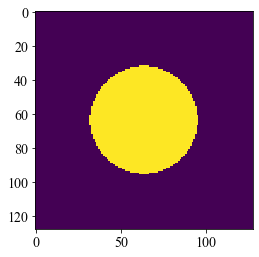

In [32]:
plt.imshow(support)

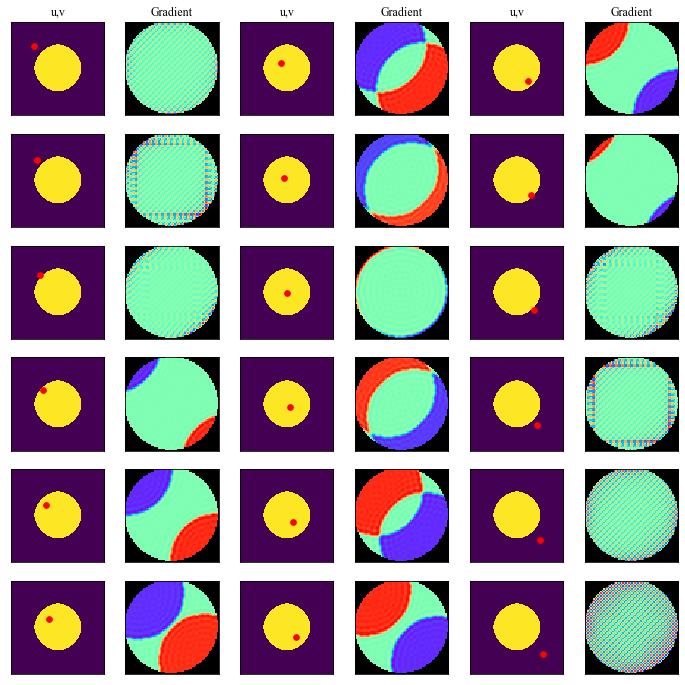

In [33]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[indices,indices,:,:])
        phases[pupil==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

#         ax[i,1+j].set_xlim(16,128-16)
#         ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(support)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('../paper/jacobian.pdf',bbox_inches='tight')

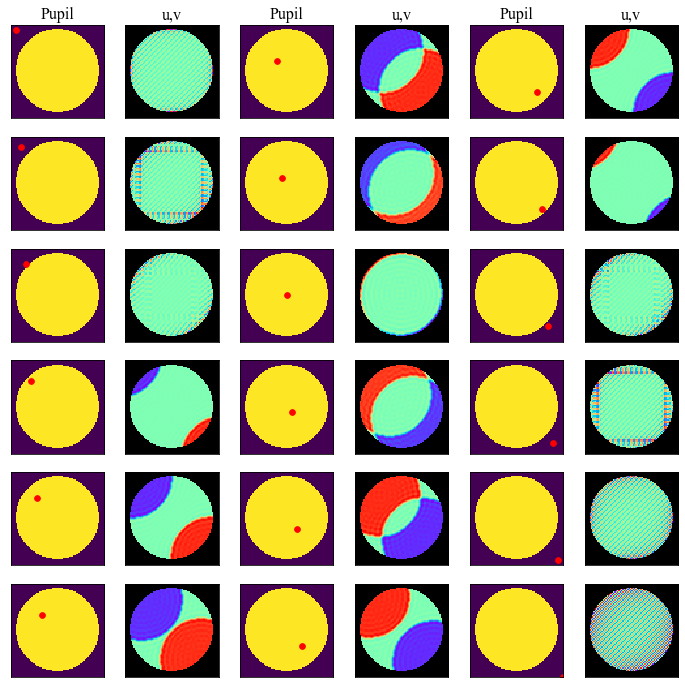

In [53]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32
fs = 16


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[indices,indices,:,:])
        phases[pupil==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xlim(32-4,128-32+4)
        ax[i,1+j].set_ylim(128-32+4,32-4)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlim(32-4,128-32+4)
        ax[i,j].set_ylim(128-32+4,32-4)

        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('../paper/jacobian.pdf',bbox_inches='tight')

In [54]:
transfer_martinache = thisgrad[support>0,:,:][:,pupil>0]

In [55]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache,full_matrices=False)

CPU times: user 53.4 ms, sys: 16.1 ms, total: 69.4 ms
Wall time: 93.7 ms


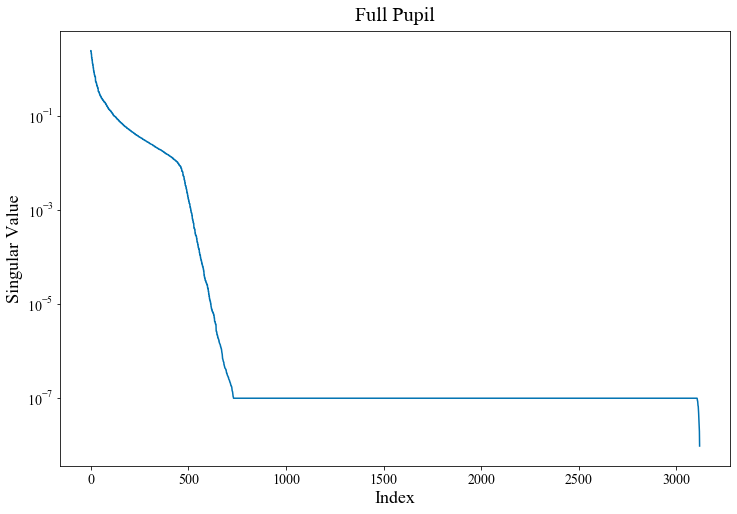

In [56]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('../paper/kerphi_singular.pdf',bbox_inches='tight')

### Now let's try a coronagraph!

In [57]:
pupil = make_pupil(0.5,npix=128)
psf = jit_dft(pupil, 64., 128)

x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])


In [58]:
x.min(),x.max()

(DeviceArray(-64., dtype=float32), DeviceArray(64., dtype=float32))

In [59]:
xx, yy = np.meshgrid(x,x)
xx.min(),xx.max()

(DeviceArray(-64., dtype=float32), DeviceArray(64., dtype=float32))

In [60]:
def make_stop(psf):
    x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < 13
    stop = onp.ones_like(rr)
    stop[mask] = 0
    return stop



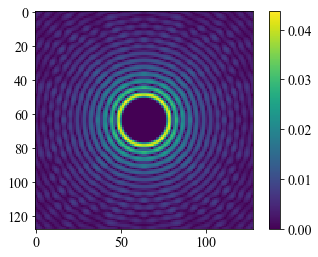

In [61]:
stop = make_stop(psf)
stopped = stop*psf
plt.imshow(np.abs(stopped)/np.max(np.abs(psf)))
plt.colorbar()

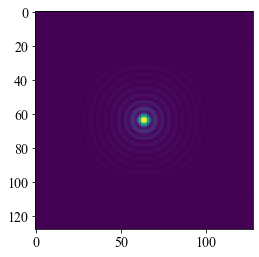

In [62]:
plt.imshow(np.abs(psf))

In [63]:
lyot = make_pupil(0.4,npix=128)

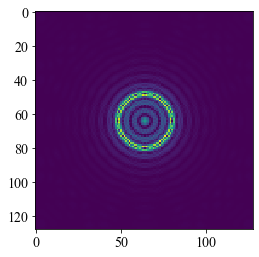

In [64]:
plt.imshow(np.abs(onp.fft.fftshift(fft(stopped))))

In [65]:
lyot_plane = jit_dft(stopped, 64, 128)

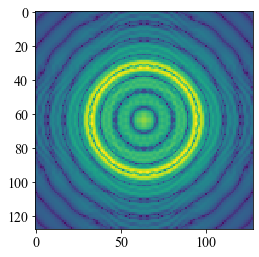

In [66]:
plt.imshow(np.abs(lyot_plane)**0.25)

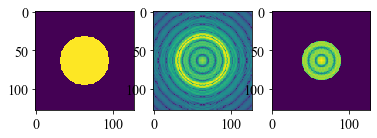

In [67]:
f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(np.abs(pupil))
ax2.imshow(np.abs(lyot_plane)**0.2)
ax3.imshow(np.abs(lyot_plane*lyot)**0.2)

In [68]:
final = jit_dft(lyot_plane*lyot, 64, 128)

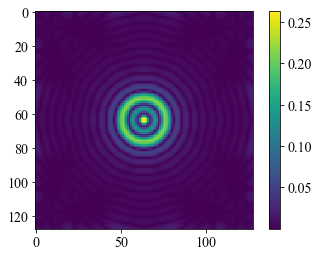

In [69]:
plt.imshow(np.abs(final/np.max(np.abs(pupil))))
plt.colorbar()

In [70]:
def propagate(field):
    return jit_dft(field, 64, 128)

def get_speckles(screen):
    return np.abs(propagate(lyot*propagate(stop*get_psf(screen,nlam=64,npix=128))))

In [71]:
print(pupil.shape)
print(stop.shape)
print(lyot.shape)

(128, 128)
(128, 128)
(128, 128)


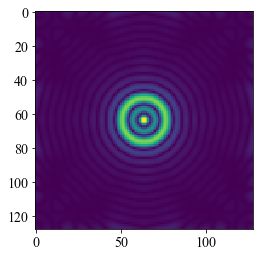

In [72]:
speckles = get_speckles(np.zeros_like(pupil))
plt.imshow(np.abs(speckles))

In [73]:
speckle_grad = jacfwd(get_speckles)

In [74]:
%%time 
new_grad = speckle_grad(np.zeros_like(pupil))
new_grad

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'float'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 8.14 s, sys: 11.1 s, total: 19.3 s
Wall time: 8.58 s


DeviceArray([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               ...,
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

              [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               ...,
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

              [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               ...,
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.],
               [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

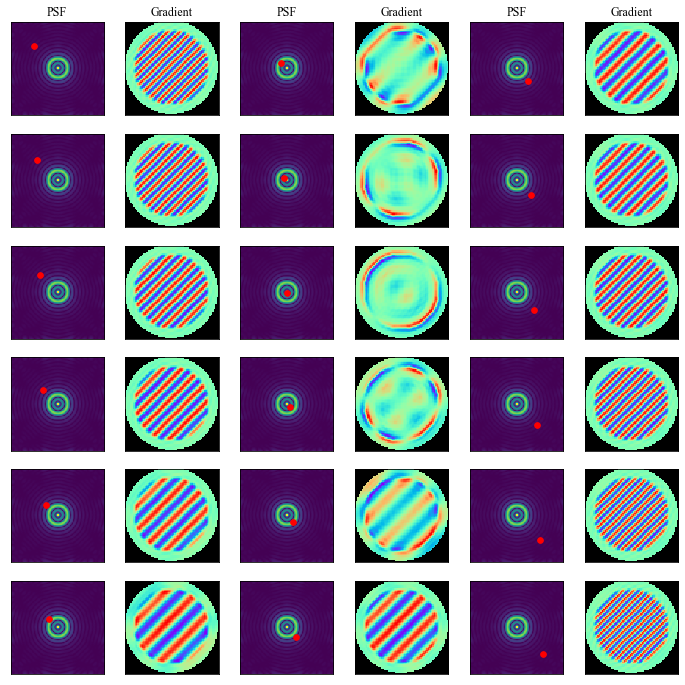

In [75]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        phases = onp.copy(new_grad[indices,indices,:,:])
        phases[pupil==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('speckle_jacobian.png',bbox_inches='tight')
plt.savefig('../paper/speckle_jacobian.pdf',bbox_inches='tight')

### Let's make this into a phase transfer matrix

In [76]:
new_grad.shape

(128, 128, 128, 128)

In [77]:
test = np.reshape(new_grad,(128**2,128**2))

In [78]:
test.shape

(16384, 16384)

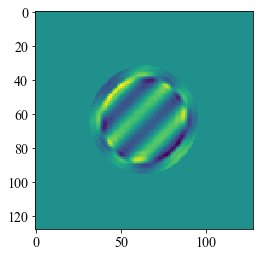

In [79]:
plt.imshow(np.reshape(test,(128,128,128,128))[55,55,:,:])

In [87]:
transfer = new_grad[:,:,pupil>0].reshape(128**2,np.sum(pupil>0))

In [88]:
transfer.shape

(16384, 3168)

In [89]:
%%time
u, s, v = np.linalg.svd(transfer,full_matrices=False)

CPU times: user 91.8 ms, sys: 52.5 ms, total: 144 ms
Wall time: 39.5 ms


Text(0.5, 1.01, 'Lyot')

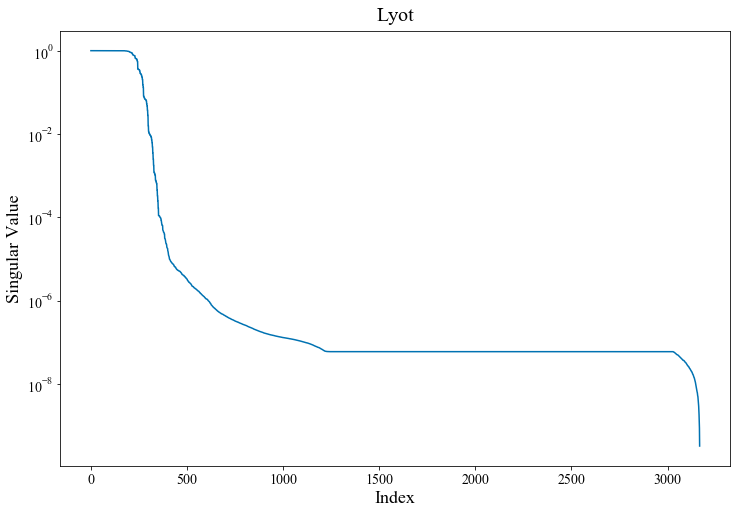

In [90]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Singular Value Spectrum of a Lyot Coronagraph',fontsize=24,y=1.01)
plt.title('Lyot', y=1.01,fontsize=20)
# plt.savefig('coronagraph_singular.png',bbox_inches='tight')
# plt.savefig('../paper/coronagraph_singular.pdf',bbox_inches='tight')

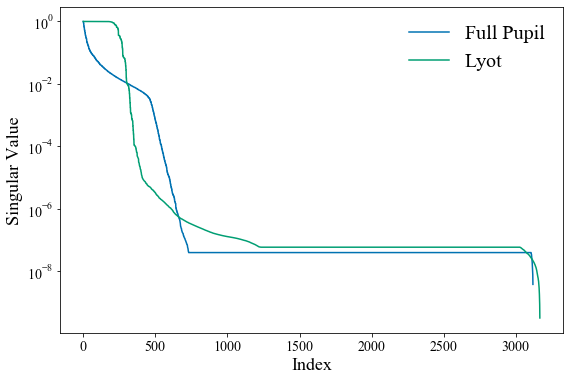

In [91]:
fig = plt.figure(figsize=(9.0,6.0))
plt.plot(s1/s1[0],label='Full Pupil')
plt.plot(s/s[0],label='Lyot')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.axvline(230)
# plt.axvline(1225)
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
# plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=20,frameon=False)
plt.savefig('all_singular.png',bbox_inches='tight')
plt.savefig('../paper/all_singular.pdf',bbox_inches='tight')

In [92]:
s[1000]/s[0]

DeviceArray(1.2982657e-07, dtype=float32)

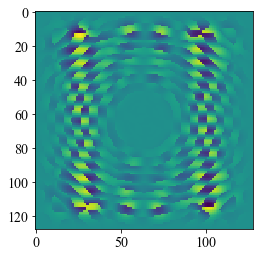

In [93]:
plt.imshow(u[:,0].reshape(128,128))

(32, 96)

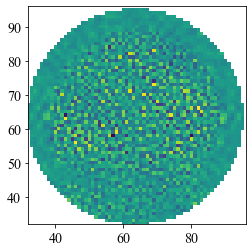

In [94]:
mask = pupil>0
wavefront = onp.ones_like(pupil)
wavefront[mask] *= v[1100,:]
wavefront[~mask] = np.nan

plt.imshow(wavefront)

plt.xlim(32,128-32)
plt.ylim(32,128-32)

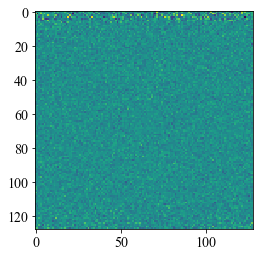

In [95]:
plt.imshow(u[:,1136].reshape(128,128))

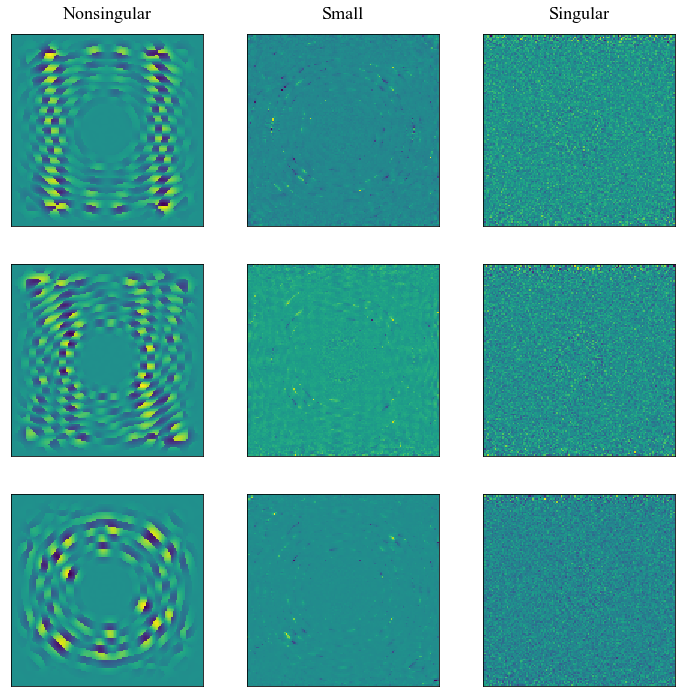

In [96]:
nsets = 3

fig, axes = plt.subplots(nsets,3,figsize=(12.0,12/3.*nsets),sharex=True, sharey=True)

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)

for j in range(nsets):
    axes[j,0].imshow(u[:,j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,1].imshow(u[:,600+j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,2].imshow(u[:,1500+j*10].reshape(128,128))
    
plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')

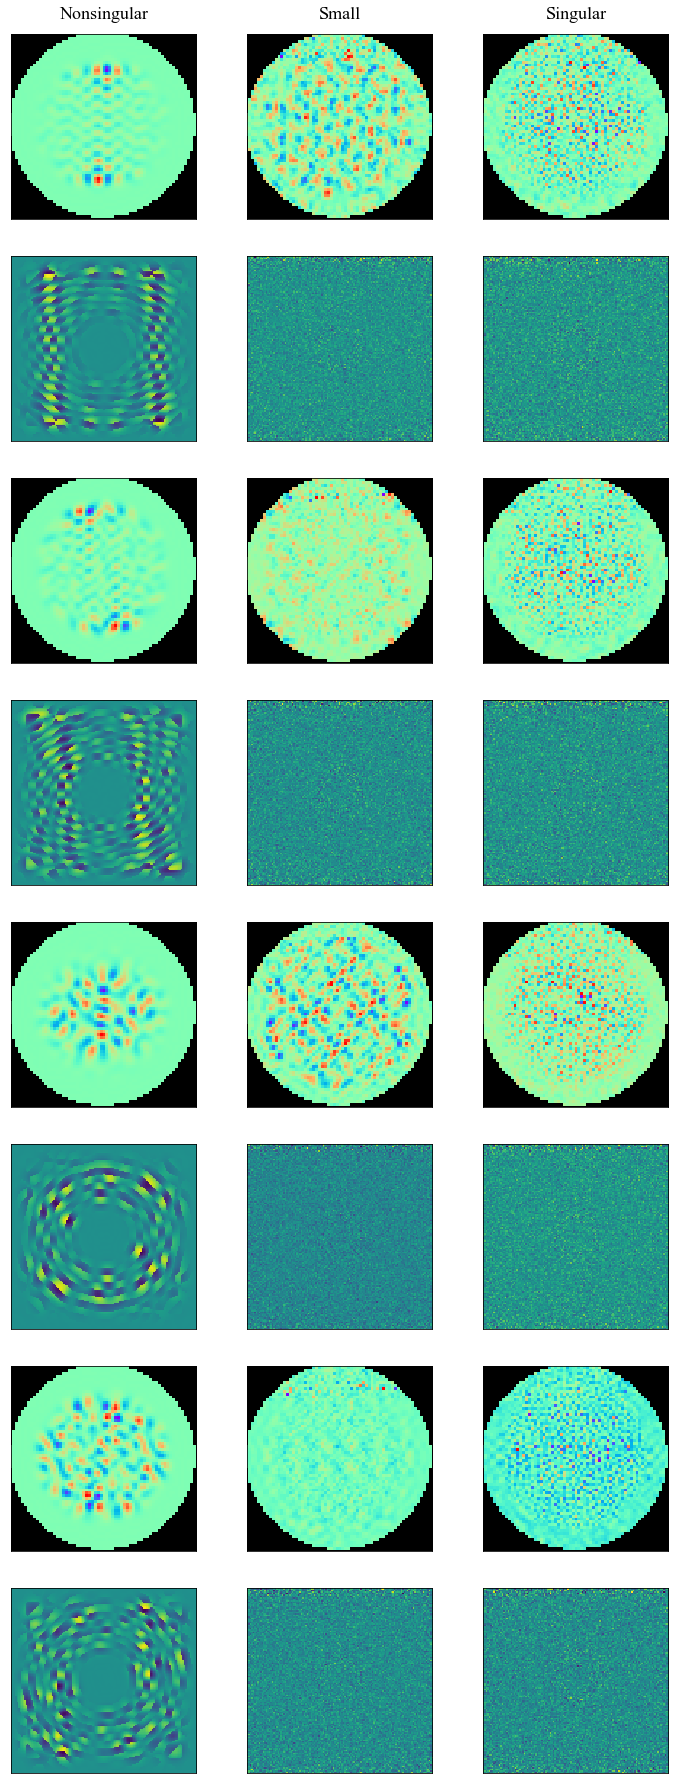

In [102]:
nsets = 4

fig, axes = plt.subplots(nsets*2,3,figsize=(12.0,12/3.*(nsets*2)))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)


for j in range(nsets):
    axes[j*2+1,0].imshow(u[:,j*10].reshape(128,128))
    wavefront = onp.ones_like(pupil)
    wavefront[mask] *= v[j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,0].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

    axes[j*2,0].set_xlim(32,128-32)
    axes[j*2,0].set_ylim(128-32,32)

    
for j in range(nsets):
    axes[j*2+1,1].imshow(u[:,1500+j*10].reshape(128,128))
    wavefront = onp.ones_like(pupil)
    wavefront[mask] *= v[600+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,1].imshow(wavefront,cmap=phasemap)
    axes[j*2,1].set_xlim(32,128-32)
    axes[j*2,1].set_ylim(128-32,32)

for j in range(nsets):
    axes[j*2+1,2].imshow(u[:,1600+j*10].reshape(128,128))
    wavefront = onp.ones_like(pupil)
    wavefront[mask] *= v[1000+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,2].imshow(wavefront,cmap=phasemap)
    axes[j*2,2].set_xlim(32,128-32)
    axes[j*2,2].set_ylim(128-32,32)

plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')

In [98]:
wavefront = onp.ones_like(pupil)
wavefront[mask] *= v[1000,:]
wavefront[~mask] = 0
wavefront = 0.001*wavefront/wavefront.max()

In [99]:
test = get_speckles(wavefront)
ref = get_speckles(np.zeros_like(pupil))

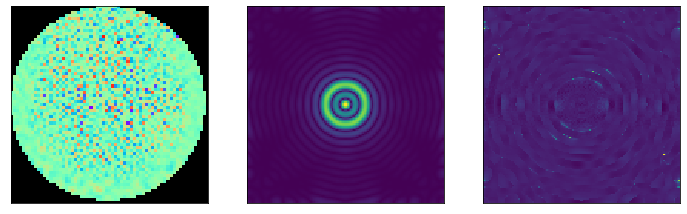

In [100]:
fig, axes = plt.subplots(1,3,figsize=[12.0,4.0])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')
black = onp.ones_like(wavefront)
black[~mask] = np.nan
axes[0].imshow(wavefront*black,cmap=phasemap)
axes[0].set_xlim(32,128-32)
axes[0].set_ylim(128-32,32)
axes[1].imshow(np.abs(test))
axes[2].imshow((np.abs(test)-np.abs(ref))/np.median(np.abs(ref)))
# plt.colorbar()

In [86]:
wavefront = onp.ones_like(pupil)
wavefront[mask] *= v[0,:]
wavefront[~mask] = 0
wavefront = 0.001*wavefront/wavefront.max()

In [87]:
test = get_speckles(wavefront)
ref = get_speckles(np.zeros_like(pupil))

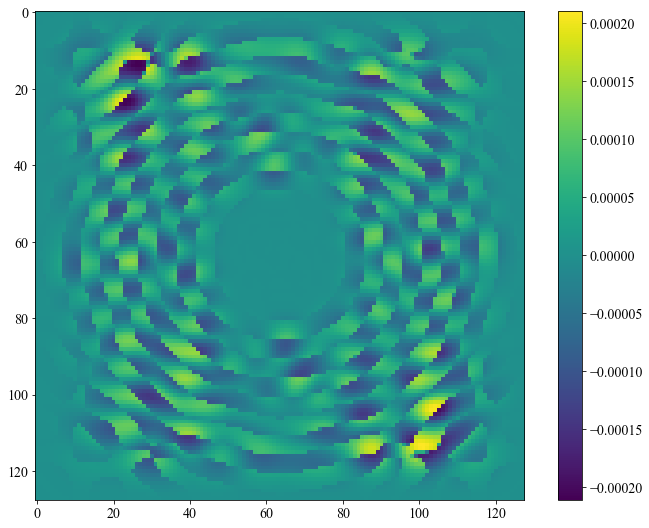

In [88]:
plt.imshow(np.abs(test)-np.abs(ref))
plt.colorbar()

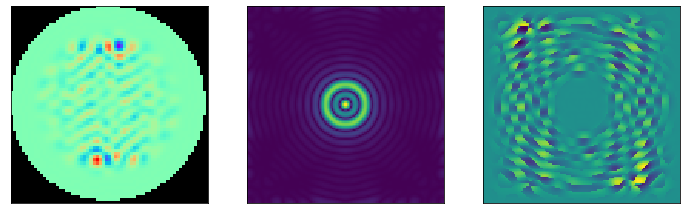

In [89]:
fig, axes = plt.subplots(1,3,figsize=[12.0,4.0])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')
black = onp.ones_like(wavefront)
black[~mask] = np.nan
axes[0].imshow(wavefront*black,cmap=phasemap)
axes[0].set_xlim(32,128-32)
axes[0].set_ylim(128-32,32)
axes[1].imshow(np.abs(test))
axes[2].imshow((np.abs(test)-np.abs(ref))/np.median(np.abs(ref)))
# plt.colorbar()

###  How singular are these vectors?

In [92]:
def mad(a,b):
    return onp.nanmedian(np.abs(a-b))

from tqdm import tqdm

In [93]:
mads = []
mads2 = []
mads3 = []

ref = get_speckles(np.zeros_like(pupil))

for j in tqdm(range(s.shape[0])):
    wavefront = onp.ones_like(pupil)
    wavefront[mask] *= v[j,:]
    wavefront[~mask] = 0
    wavefront = 0.001*wavefront/wavefront.max()
    mads.append(mad(np.abs(get_speckles(wavefront)),ref))
    mads2.append(mad(np.abs(get_speckles(wavefront*10)),ref))
    mads3.append(mad(np.abs(get_speckles(wavefront*100)),ref))

mads = np.array(mads)/np.max(ref)
mads2 = np.array(mads2)/np.max(ref)
mads3 = np.array(mads3)/np.max(ref)

100%|██████████| 3168/3168 [03:53<00:00, 13.57it/s]


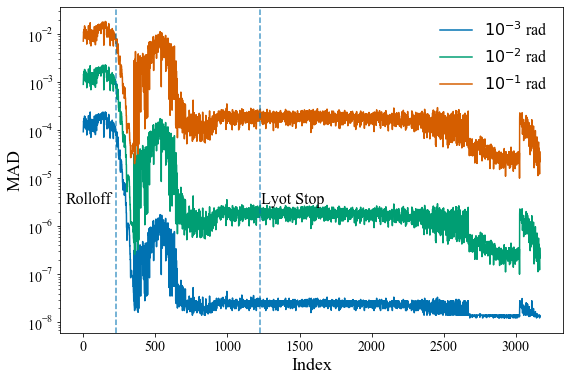

In [127]:
fig = plt.figure(figsize=(9.0,6.0))
plt.plot(mads,label=r'$10^{-3}$ rad')
plt.plot(mads2,label=r'$10^{-2}$ rad')
plt.plot(mads3,label=r'$10^{-1}$ rad')

plt.yscale('log')
plt.ylabel('MAD')
plt.xlabel('Index')
# plt.title('Singular Value Spectrum of a Lyot Coronagraph',fontsize=24,y=1.01)
# plt.title('Lyot', y=1.01,fontsize=20)
plt.axvline(230,linestyle='--',alpha=0.7)
plt.text(230-350,0.03e-4,'Rolloff',fontsize=16)
# plt.axvline(441,linestyle='--',alpha=0.7)
# plt.text(441+10,0.02e-4,'Kernel',fontsize=16)
plt.axvline(1225,linestyle='--',alpha=0.7)
plt.text(1225+10,0.03e-4,'Lyot Stop',fontsize=16)
plt.savefig('coronagraph_mad.png',bbox_inches='tight')
plt.legend(loc=1,frameon=False,fontsize=16)
plt.savefig('../paper/coronagraph_mad.pdf',bbox_inches='tight')

In [95]:
np.min(np.where(s/s[0]<1e-4))

DeviceArray(360, dtype=int32)

### Pretty singular! 

How many are under the Lyot stop?

In [ ]:
print('Minimum Lyot index:',np.min(np.where(s==s[1000])))
print('# Lyot:',s.shape[0]-np.min(np.where(s==s[1000])))
print('# Lyot pixels:',np.sum(mask)-np.sum(lyot>0))

How many approximately singular values are there?

In [ ]:
print('# "True" kernel:',np.min(np.where(s==s[1000]))-np.max(np.where(s/s[0] > 1e-4)))
print('# Rolloff:',np.max(np.where(s/s[0] > 1e-4))-np.max(np.where(s/s[0] > 0.5)))


In [ ]:
np.sum(mask)-np.sum(lyot>0)

In [ ]:
np.max(np.where(s/s[0] > 1e-4))

In [ ]:
plt.plot(s/s[0] > 0.5)

### What is the power spectrum of phase and amplitude variation like as a function of singular value index?

In [ ]:
support_lyot = convolve2d(lyot,lyot,mode='same')>0

In [ ]:
enclosed = []
for j in tqdm(range(s.shape[0])):

    thisuv = np.abs(get_uv(u[:,j].reshape((128,128))))**2.
    enclosed.append(thisuv[support].sum()/thisuv[~support].sum())
enclosed = np.array(enclosed)

In [ ]:
plt.imshow(thisuv)

In [ ]:
np.min(np.where(enclosed<1e6))

In [ ]:
plt.plot(enclosed)
# plt.yscale('log')

### Now let's simulate a planet!

In [ ]:
a, b = 1.0, 1.0
tilt = a*xx + b*yy
tilt /= tilt.max()
nld = 20

tilt *= (nld*2*np.pi)

In [ ]:
plt.imshow(tilt)
plt.colorbar()

In [ ]:
planet = get_speckles(tilt)

In [ ]:
plt.imshow(planet)

In [ ]:
planet /= planet.max()
planet *= 1.e-2

### Now let's get a projection operator down to the kernel space

In [ ]:
kernel = u[:,441:]
tangent = u[:,:441]

In [ ]:
obs = planet+ref/ref.max() 
component = np.dot(u[:,441:].T,obs.ravel())
# kernel_speckles = np.dot(kernel.T,component).reshape((128,128))

In [ ]:
component.shape

In [ ]:
plt.imshow(kernel)

In [ ]:
plt.imshow(planet+ref-bad)

In [ ]:
component = np.dot(u[:,:441].T,ref.ravel())
bad = np.dot(component,u[:,:441].T).reshape((128,128))

In [ ]:
plt.imshow(bad)

In [ ]:
holder_kernel = []
holder_tangent = []

for j in range(10):
    test = get_speckles(0.1*np.random.randn(*pupil.shape))
    obs = planet+test/test.max() 
    component = np.dot(kernel.T,obs.ravel())
    holder_kernel.append(component)
    ortho = np.dot(tangent.T,obs.ravel())
    holder_tangent.append(ortho)
holder_kernel = np.array(holder_kernel)
holder_tangent = np.array(holder_tangent)

In [ ]:
plt.errorbar(np.arange(holder_kernel.shape[1]),holder_kernel.mean(axis=0),yerr=holder_kernel.std(axis=0),linestyle='none')

In [ ]:
plt.errorbar(np.arange(holder_tangent.shape[1]),holder_tangent.mean(axis=0),yerr=holder_tangent.std(axis=0),linestyle='none')